In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler

import torchvision.datasets as dset
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

import random

from torch.utils.data import DataLoader

from tqdm.notebook import tqdm

In [2]:
DATASET_DIR = './data/'

BATCH_SIZE = 256
LEARNING_RATE = 0.001
EPOCHS = 10

USE_CUDA = torch.cuda.is_available() 
DEVICE = torch.device("cuda" if USE_CUDA else "cpu") 
print("Working with", DEVICE)

Working with cuda


In [3]:
image_height = 224

transforms_ = transforms.Compose([transforms.ToTensor(),
                                    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                        std=[0.229, 0.224, 0.225])])

dataset = dset.ImageFolder(root=DATASET_DIR+'train_ae/doggy', transform = transforms_)
dataLoader = torch.utils.data.DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)


In [4]:
class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=2, stride=2, bias=False),
            nn.LeakyReLU(),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=2, stride=2, bias=False),
            nn.LeakyReLU(),
            nn.Conv2d(in_channels=64, out_channels=256, kernel_size=2, stride=2, bias=False),
            nn.LeakyReLU(),
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=2, stride=2, bias=False),
            Reshape((-1,14*14*512)),
            nn.Linear(14*14*512, 2048),
            nn.LeakyReLU(),
        )
        self.decoder = nn.Sequential(
            nn.Linear(2048, 14*14*512),
            nn.LeakyReLU(),
            Reshape((-1,512,14,14)),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(in_channels=512, out_channels=256, kernel_size=2, stride=2, bias=False),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(in_channels=256, out_channels=64, kernel_size=2, stride=2, bias=False),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=2, stride=2, bias=False),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(in_channels=32, out_channels=3, kernel_size=2, stride=2, bias=False),
            nn.Sigmoid()
        )
    def forward(self, x):
        feature = self.encoder(x)
        out = self.decoder(feature)
        return out, feature

In [5]:
class Reshape(nn.Module):
    def __init__(self, shape):
        super(Reshape, self).__init__()
        self.shape = shape
    def forward(self, x):
        return x.view(*self.shape)

In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = AutoEncoder().to(device)
loss_func = nn.MSELoss().to(device)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer,threshold=0.1, patience=1, mode='min')

for i in tqdm(range(EPOCHS), desc = 'EPOCHS'):
    for _, [image, _] in tqdm(enumerate(dataLoader), desc = 'training'):
        x = image.to(device)
        y_= image.to(device)
        
        optimizer.zero_grad()
        output,_ = model(x)
        loss = loss_func(output, y_)
        loss.backward()
        optimizer.step()
 
    scheduler.step(loss)
    print('Epoch: {}, Loss: {}, LR: {}'.format(i, loss.item(), scheduler.optimizer.state_dict()['param_groups'][0]['lr']))

EPOCHS:   0%|          | 0/10 [00:00<?, ?it/s]

training: 0it [00:00, ?it/s]

Epoch: 0, Loss: 1.1076579093933105, LR: 0.001


training: 0it [00:00, ?it/s]

Epoch: 1, Loss: 1.0548863410949707, LR: 0.001


training: 0it [00:00, ?it/s]

Epoch: 2, Loss: 0.9549311399459839, LR: 0.001


training: 0it [00:00, ?it/s]

Epoch: 3, Loss: 0.9378151297569275, LR: 0.001


training: 0it [00:00, ?it/s]

Epoch: 4, Loss: 0.956081211566925, LR: 0.0001


training: 0it [00:00, ?it/s]

Epoch: 5, Loss: 0.9168379306793213, LR: 0.0001


training: 0it [00:00, ?it/s]

Epoch: 6, Loss: 0.9871150255203247, LR: 1e-05


training: 0it [00:00, ?it/s]

Epoch: 7, Loss: 0.9223852753639221, LR: 1e-05


training: 0it [00:00, ?it/s]

Epoch: 8, Loss: 0.9192450642585754, LR: 1.0000000000000002e-06


training: 0it [00:00, ?it/s]

Epoch: 9, Loss: 0.891267716884613, LR: 1.0000000000000002e-06


In [7]:
for _, [image, _] in tqdm(enumerate(dataLoader), desc = 'training'):
    print(image.shape)
    break

training: 0it [00:00, ?it/s]

torch.Size([256, 3, 224, 224])


In [8]:
def imreshape_(img):
    n_img = img
    C,W,H = img.shape
    n_img = n_img.reshape(W, H, C)
    n_img[:,:,0] = img[0,:,:]
    n_img[:,:,1] = img[1,:,:]
    n_img[:,:,2] = img[2,:,:]
    return n_img

In [9]:
transform_Tensor = transforms.Compose([transforms.ToTensor()])
inp = transform_Tensor(dataset[0][0].numpy().reshape(3,224,224)).reshape(1,3,224,224).to(device)
img = model(inp)
print(img[0])
#plt.imshow(imreshape_(img.detach().cpu().numpy(), cmap='gray'))

tensor([[[[1.7555e-04, 4.3113e-04, 3.8405e-04,  ..., 9.9991e-01,
           9.9999e-01, 9.9979e-01],
          [3.6203e-04, 1.6011e-03, 8.9498e-04,  ..., 1.0000e+00,
           9.9998e-01, 1.0000e+00],
          [6.9708e-04, 7.9944e-05, 6.1311e-04,  ..., 9.9997e-01,
           9.9992e-01, 9.9997e-01],
          ...,
          [6.9701e-05, 3.3537e-05, 2.5344e-05,  ..., 1.0000e+00,
           9.9995e-01, 1.0000e+00],
          [3.4983e-06, 1.9992e-08, 2.6893e-05,  ..., 9.9991e-01,
           9.9974e-01, 9.9988e-01],
          [2.0566e-05, 5.1521e-06, 1.4359e-05,  ..., 1.0000e+00,
           9.9974e-01, 1.0000e+00]],

         [[5.3582e-05, 1.0855e-04, 3.5686e-04,  ..., 9.9994e-01,
           9.9994e-01, 9.9998e-01],
          [2.8716e-04, 7.4637e-04, 5.9524e-04,  ..., 9.9999e-01,
           1.0000e+00, 1.0000e+00],
          [4.9146e-04, 3.8977e-04, 9.3970e-05,  ..., 9.9998e-01,
           9.9991e-01, 9.9996e-01],
          ...,
          [2.7081e-06, 3.0734e-06, 1.4347e-06,  ..., 9.9997

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0
0


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0
0


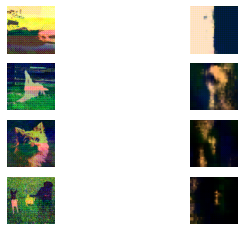

In [10]:
model.eval()
rows = 4
random.seed(42)
for c in range(rows):
    plt.subplot(rows, 2, c*2+1)
    rand_idx = random.randint(0, 4072)
    plt.imshow(imreshape_(dataset[rand_idx][0].view(3, 224,224)), cmap = 'gray')
    plt.axis('off')
    plt.subplot(rows, 2, c*2+2)
    inp = transform_Tensor(dataset[rand_idx][0].numpy().reshape(3,224,224)).reshape(1,3,224,224).to(device)
    img = model(inp)
    plt.imshow(imreshape_(img[0].view(3,224,224).detach().cpu().numpy()), cmap='gray')
    plt.axis('off')
    print(dataset.targets[rand_idx])
plt.show()